<a href="https://colab.research.google.com/github/wa2eli/airbnb_new_customers/blob/master/Wael_Rayes_Udacity_Project_Predict_Bike_Sharing_Demand.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [41]:
!pip install -U pip
!pip install -U setuptools wheel
!pip install -U "mxnet<2.0.0" bokeh==2.0.1
!pip install autogluon --no-cache-dir
# Without --no-cache-dir, smaller aws instances may have trouble installing

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [42]:
# create the .kaggle directory and an empty kaggle.json file
!mkdir -p /root/.kaggle
!touch /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

In [43]:
# Fill in your user name and key from creating the kaggle account and API token file
import json
kaggle_username = "waelrayes"
kaggle_key = "792affca764a8012ea3fb5e89e1d3915"

# Save API token the kaggle.json file
with open("/root/.kaggle/kaggle.json", "w") as f:
    f.write(json.dumps({"username": kaggle_username, "key": kaggle_key}))

In [44]:
# Download the dataset, it will be in a .zip file so you'll need to unzip it as well.
!kaggle competitions download -c bike-sharing-demand
# If you already downloaded it you can use the -o command to overwrite the file
!unzip -o bike-sharing-demand.zip

bike-sharing-demand.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  bike-sharing-demand.zip
  inflating: sampleSubmission.csv    
  inflating: test.csv                
  inflating: train.csv               


In [45]:
import pandas as pd
from autogluon.tabular import TabularPredictor

In [46]:
# Create the train dataset in pandas by reading the csv
# Set the parsing of the datetime column so you can use some of the `dt` features in pandas later
train = pd.read_csv("/content/train.csv", parse_dates=['datetime'])
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [47]:
# Simple output of the train dataset to view some of the min/max/varition of the dataset features.
train.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


In [48]:
# Create the test pandas dataframe in pandas by reading the csv, remember to parse the datetime!
test = pd.read_csv("/content/test.csv", parse_dates=['datetime'])
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [49]:
# Same thing as train and test dataset
submission = pd.read_csv("/content/sampleSubmission.csv", parse_dates=['datetime'])
submission.head()

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


In [50]:
predictor = TabularPredictor(
    label = "count",
    eval_metric = 'root_mean_squared_error',
    learner_kwargs = {"ignored_columns": ["casual", "registered"]}
).fit(
     train_data=train,time_limit = 600, 
     presets= "best_quality")

No path specified. Models will be saved in: "AutogluonModels/ag-20230610_150741/"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20230610_150741/"
AutoGluon Version:  0.7.0
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Sat Apr 29 09:15:28 UTC 2023
Train Data Rows:    10886
Train Data Columns: 11
Label Column: count
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == int and many unique label-values observed).
	Label info (max, min, mean, stddev): (977, 1, 191.57413, 181.14445)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using F

In [51]:
predictor.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                     model   score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3  -53.128448      40.454185  537.372114                0.000869           0.252483            3       True         12
1   RandomForestMSE_BAG_L2  -53.472226      31.227702  406.350242                1.075987          49.396971            2       True         11
2          LightGBM_BAG_L2  -55.050617      30.626525  394.404166                0.474810          37.450896            2       True         10
3        LightGBMXT_BAG_L2  -60.444809      38.902518  450.271764                8.750803          93.318493            2       True          9
4    KNeighborsDist_BAG_L1  -84.125061       0.057551    0.036277                0.057551           0.036277            1       True          2
5      WeightedEnsemble_L2  -84.125061       0.058873    0.755583         

/usr/local/lib/python3.10/dist-packages/autogluon/core/utils/plots.py:138: UserWarning: AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"
  warnings.warn('AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"')


{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L1': 'StackerEnsembleModel_XT',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L2': 'StackerEnsembleModel_RF',
  'WeightedEnsemble_L3': 'WeightedEnsembleModel'},
 'model_performance': {'KNeighborsUnif_BAG_L1': -101.54619908446061,
  'KNeighborsDist_BAG_L1': -84.12506123181602,
  'LightGBMXT_BAG_L1': -131.46090891834504,
  'LightGBM_BAG_L1': -131.054161598899,
  'RandomForestMSE_BAG_L1': -116.54835939455667,
  'CatBoost_BAG_L1': -130.7898377114621,
  'ExtraTreesMSE_BAG_L1': -124.60067564699747,
  'WeightedEnsemble_

In [52]:
predictions = predictor.predict(test)
predictions.head()

0    23.082466
1    42.726414
2    46.297394
3    49.710144
4    52.091316
Name: count, dtype: float32

In [53]:
# Describe the `predictions` series to see if there are any negative values
predictions.describe()

count    6493.000000
mean      100.538467
std        90.048065
min         2.938168
25%        19.660587
50%        64.019577
75%       167.892120
max       370.645477
Name: count, dtype: float64

In [54]:
# How many negative values do we have?
predictions[predictions < 0] 

#if the output is an empty list, so we don't have negative values.

Series([], Name: count, dtype: float32)

In [55]:
# Set them to zero
# In cases where there were negative values, they could be set to zero with:
predictions[predictions < 0] = 0

In [56]:
submission["count"] = predictions
submission.to_csv("submission.csv", index=False)

In [57]:
!kaggle competitions submit -c bike-sharing-demand -f submission.csv -m "first raw submission"

100% 188k/188k [00:00<00:00, 205kB/s]
Successfully submitted to Bike Sharing Demand

In [58]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                     date                 description                        status    publicScore  privateScore  
---------------------------  -------------------  ---------------------------------  --------  -----------  ------------  
submission.csv               2023-06-10 15:19:04  first raw submission               complete  1.80836      1.80836       
submission_new_hpo.csv       2023-06-10 15:06:21  new features with hyperparameters  complete  0.57065      0.57065       
submission_new_features.csv  2023-06-10 14:55:47  new features                       complete  0.63079      0.63079       
submission.csv               2023-06-10 14:43:35  first raw submission               complete  1.80282      1.80282       


array([[<Axes: title={'center': 'datetime'}>,
        <Axes: title={'center': 'season'}>,
        <Axes: title={'center': 'holiday'}>],
       [<Axes: title={'center': 'workingday'}>,
        <Axes: title={'center': 'weather'}>,
        <Axes: title={'center': 'temp'}>],
       [<Axes: title={'center': 'atemp'}>,
        <Axes: title={'center': 'humidity'}>,
        <Axes: title={'center': 'windspeed'}>],
       [<Axes: title={'center': 'casual'}>,
        <Axes: title={'center': 'registered'}>,
        <Axes: title={'center': 'count'}>]], dtype=object)

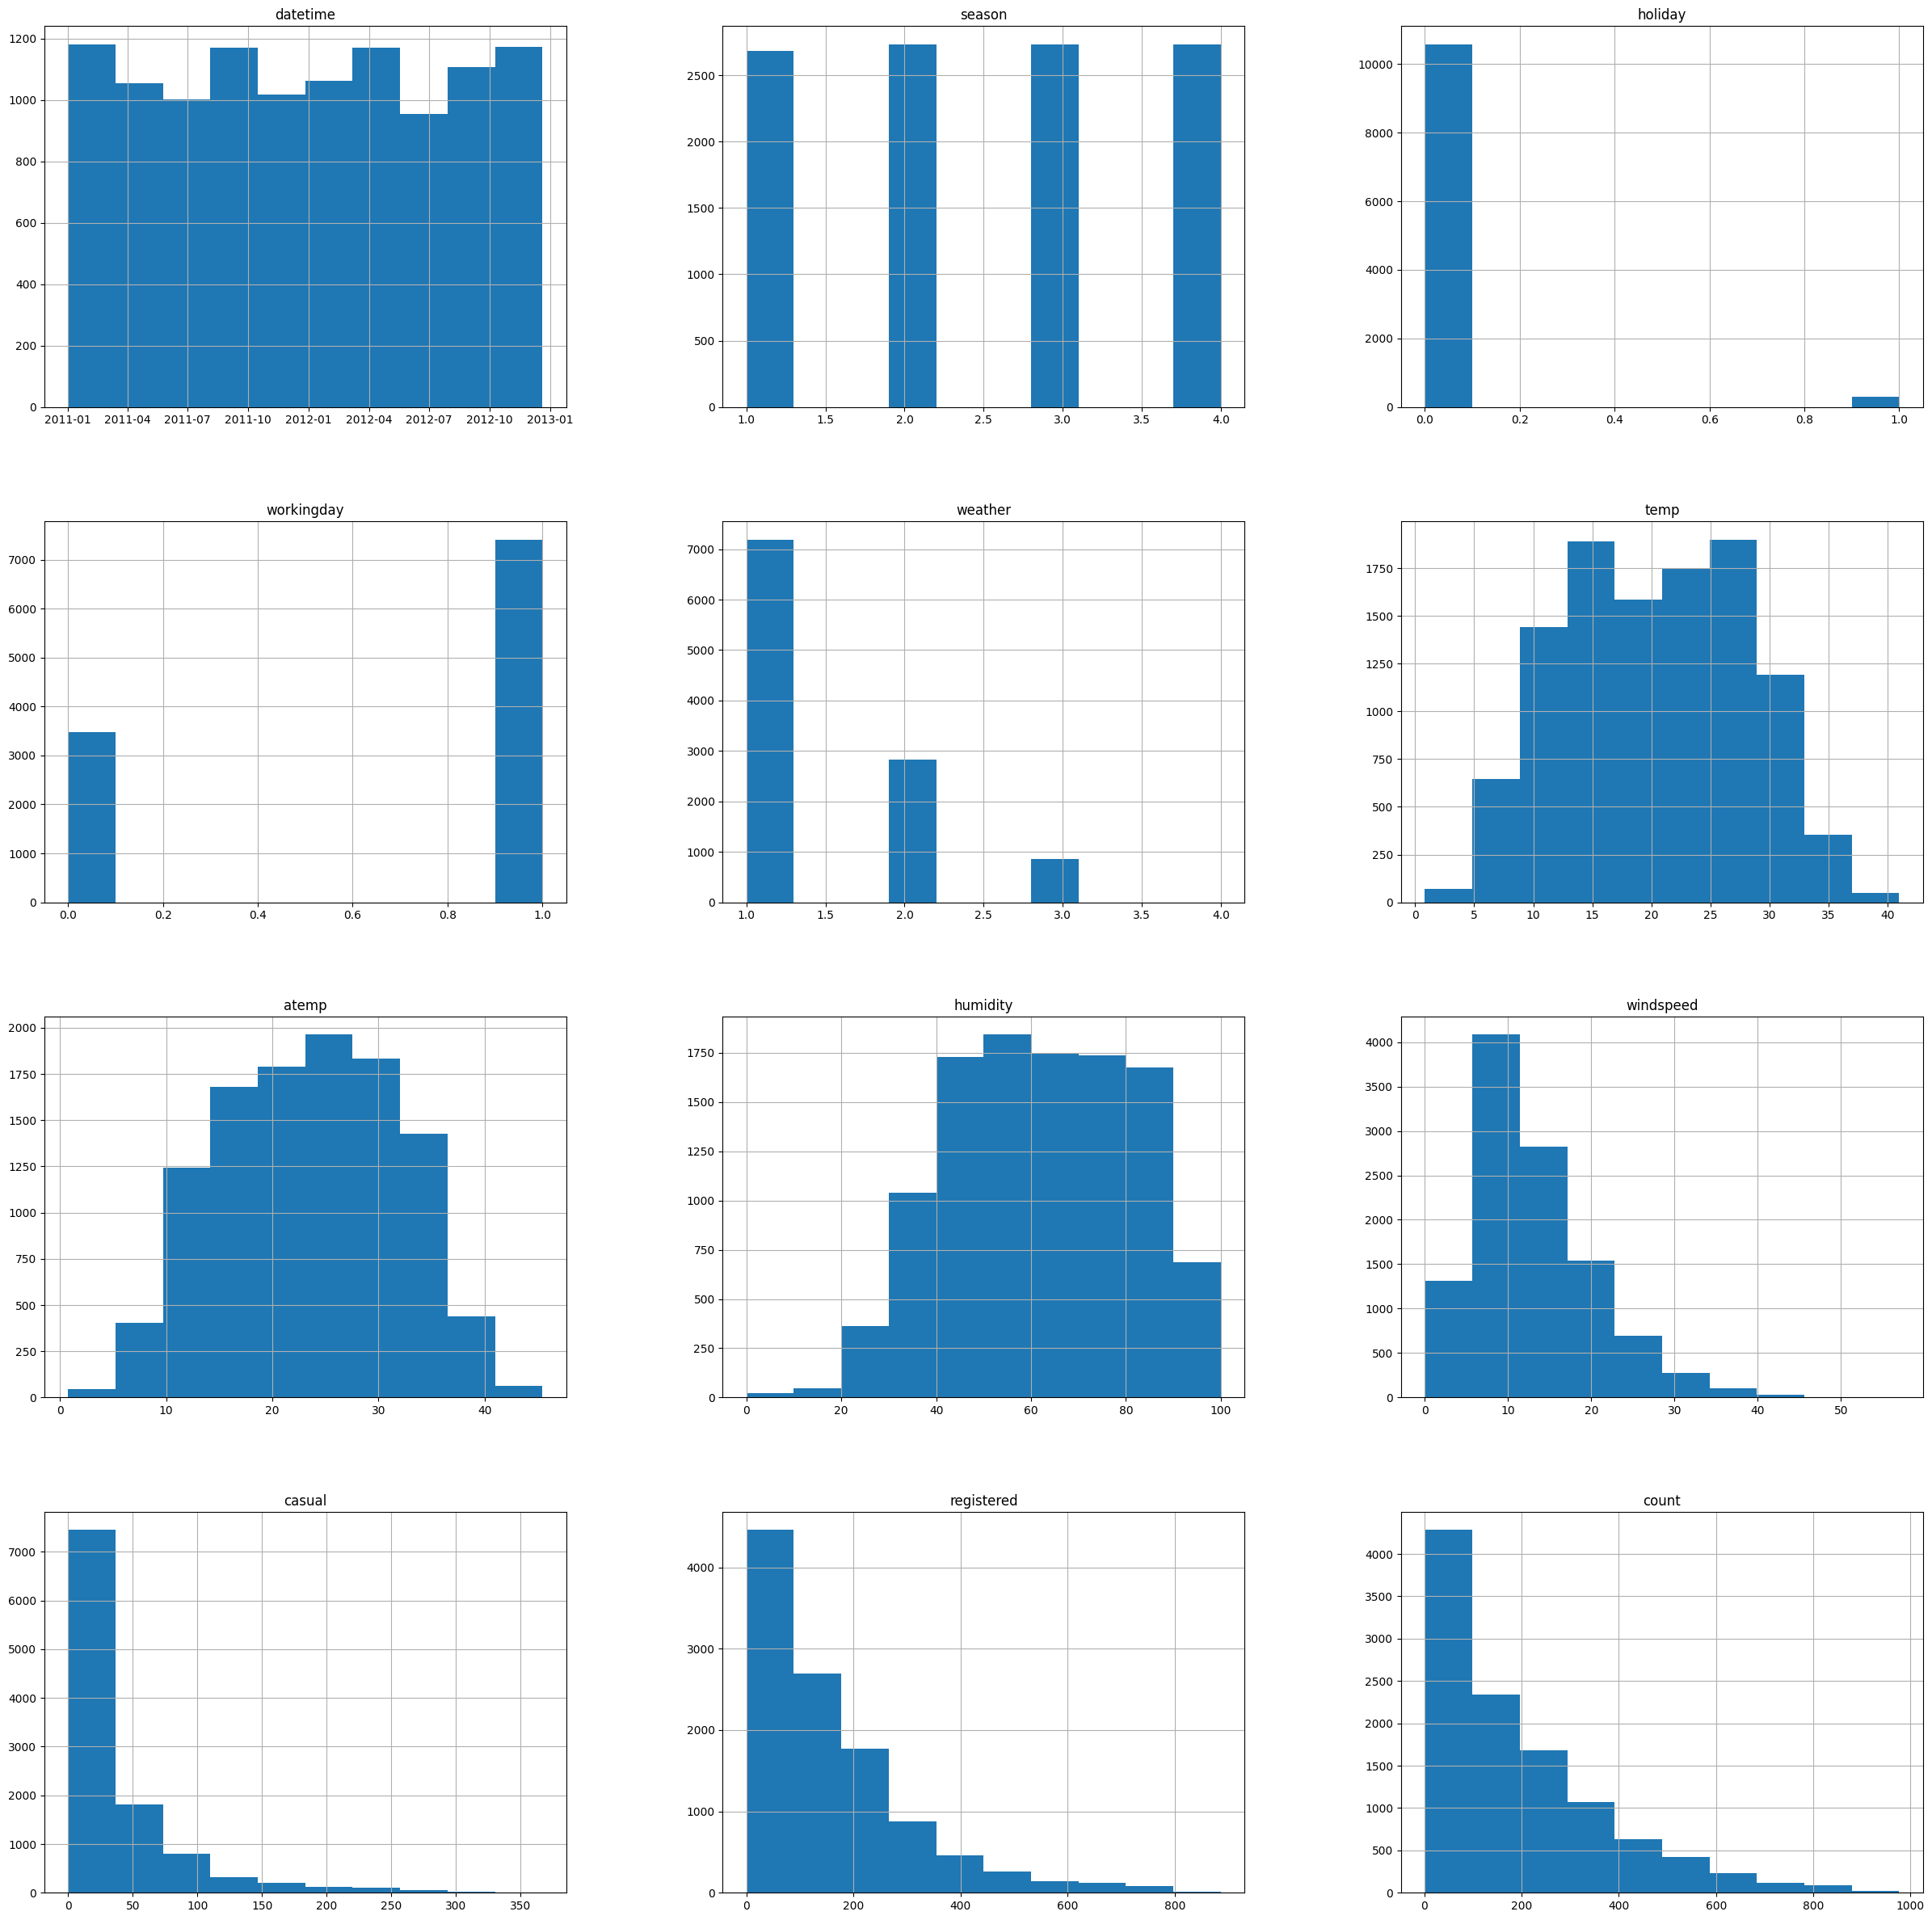

In [59]:
# Create a histogram of all features to show the distribution of each one relative to the data. This is part of the exploritory data analysis
train.hist(figsize=(30,30))

In [60]:
# creating new features
train["date-hour"] =  train['datetime'].dt.hour
train["date-day"] = train["datetime"].dt.day
train["date-month"] = train['datetime'].dt.month
train["date-year"] = train['datetime'].dt.year

test["date-hour"] =  test['datetime'].dt.hour
test["date-day"] = test["datetime"].dt.day
test["date-month"] = test['datetime'].dt.month
test["date-year"] = test['datetime'].dt.year

In [61]:
train["season"] = train["weather"].astype("category")
train["weather"] = train["weather"].astype("category")
test["season"] = test["weather"].astype("category")
test["weather"] = test["weather"].astype("category")

In [62]:
# View are new feature
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,date-hour,date-day,date-month,date-year
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,0,1,1,2011
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1,1,1,2011
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2,1,1,2011
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,3,1,1,2011
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,4,1,1,2011


array([[<Axes: title={'center': 'datetime'}>,
        <Axes: title={'center': 'holiday'}>,
        <Axes: title={'center': 'workingday'}>,
        <Axes: title={'center': 'temp'}>],
       [<Axes: title={'center': 'atemp'}>,
        <Axes: title={'center': 'humidity'}>,
        <Axes: title={'center': 'windspeed'}>,
        <Axes: title={'center': 'casual'}>],
       [<Axes: title={'center': 'registered'}>,
        <Axes: title={'center': 'count'}>,
        <Axes: title={'center': 'date-hour'}>,
        <Axes: title={'center': 'date-day'}>],
       [<Axes: title={'center': 'date-month'}>,
        <Axes: title={'center': 'date-year'}>, <Axes: >, <Axes: >]],
      dtype=object)

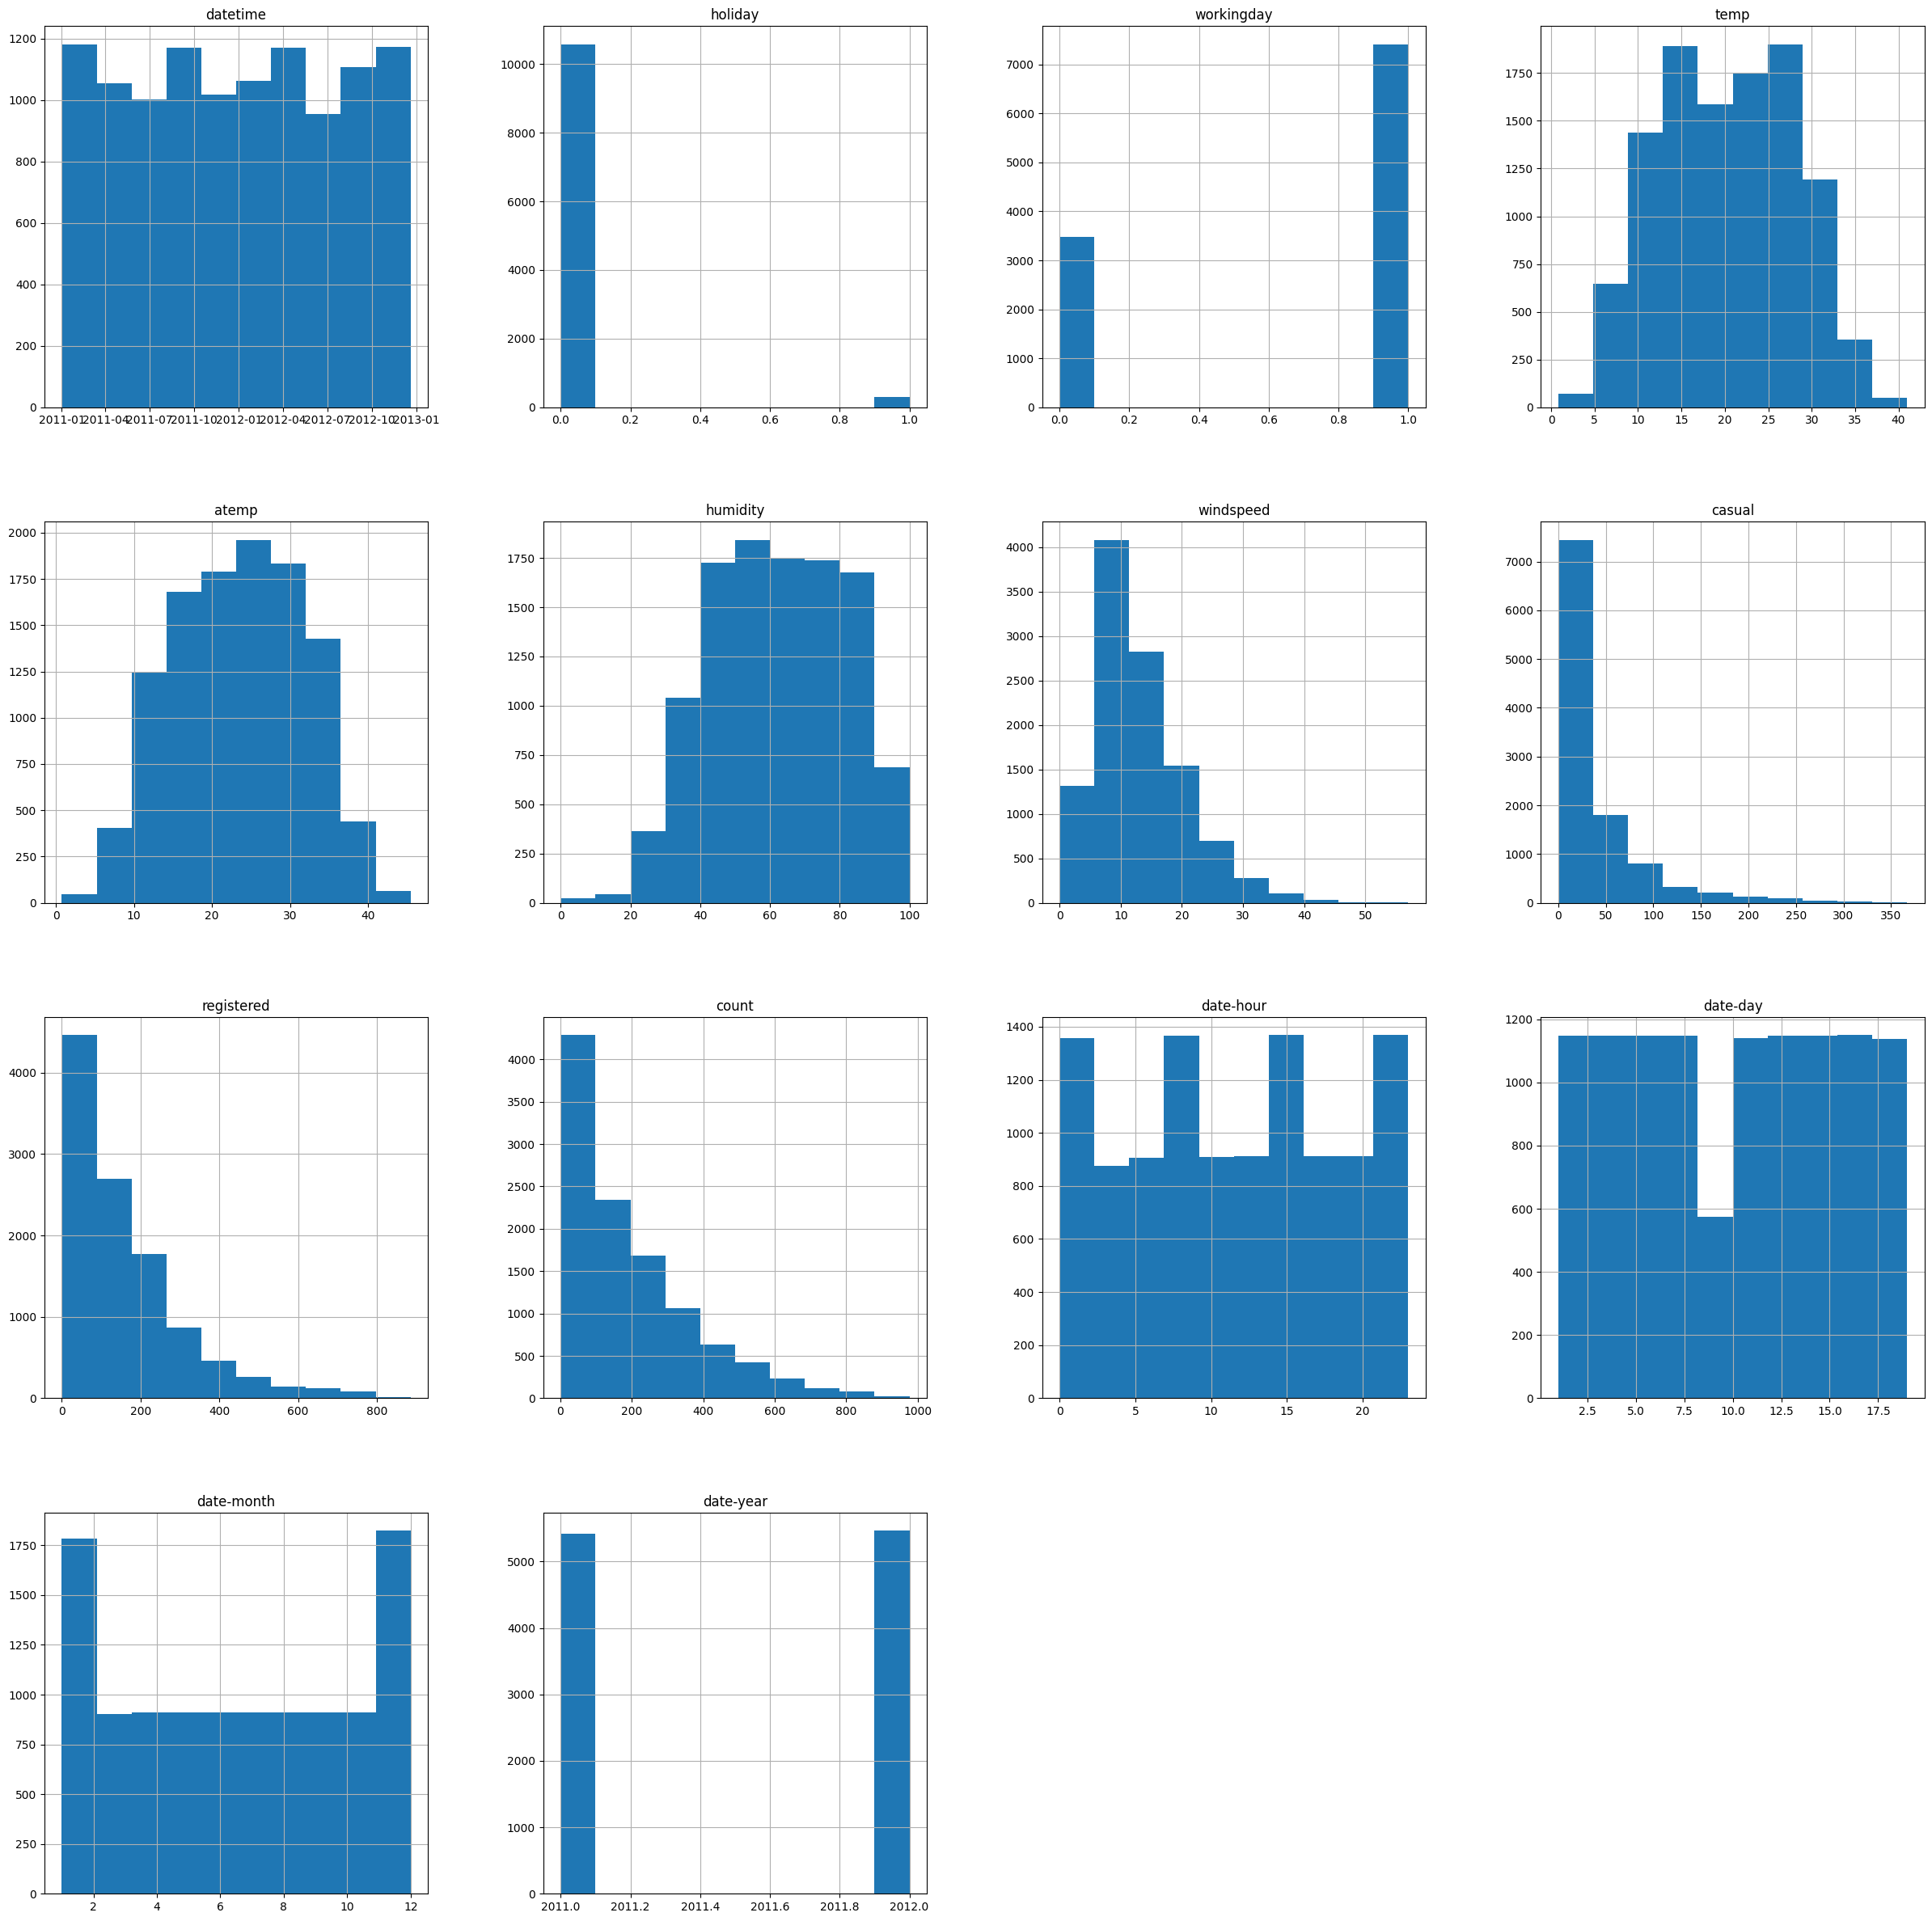

In [63]:
# View histogram of all features again now with the hour feature
train.hist(figsize=(30,30))

In [64]:
predictor_new_features = TabularPredictor(
    label = "count",
    eval_metric = 'root_mean_squared_error',
    learner_kwargs = {"ignored_columns": ["casual", "registered"]}
).fit(
     train_data=train,time_limit = 600, 
     presets= "best_quality")

No path specified. Models will be saved in: "AutogluonModels/ag-20230610_151918/"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20230610_151918/"
AutoGluon Version:  0.7.0
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Sat Apr 29 09:15:28 UTC 2023
Train Data Rows:    10886
Train Data Columns: 15
Label Column: count
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == int and many unique label-values observed).
	Label info (max, min, mean, stddev): (977, 1, 191.57413, 181.14445)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using F

In [65]:
predictor_new_features.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                     model   score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3  -30.503673      40.694751  566.899221                0.000985           0.297716            3       True         13
1          LightGBM_BAG_L2  -30.736074      37.946836  428.246826                0.660496          40.149956            2       True         10
2        LightGBMXT_BAG_L2  -31.377305      39.138992  436.336658                1.852653          48.239788            2       True          9
3          CatBoost_BAG_L2  -31.623257      37.450421  428.267418                0.164082          40.170549            2       True         12
4   RandomForestMSE_BAG_L2  -31.767039      38.016536  438.041213                0.730196          49.944343            2       True         11
5      WeightedEnsemble_L2  -32.315641      36.021416  374.586405         

/usr/local/lib/python3.10/dist-packages/autogluon/core/utils/plots.py:138: UserWarning: AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"
  warnings.warn('AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"')


{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L1': 'StackerEnsembleModel_XT',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L2': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L2': 'StackerEnsembleModel_CatBoost',
  'WeightedEnsemble_L3': 'WeightedEnsembleModel'},
 'model_performance': {'KNeighborsUnif_BAG_L1': -101.54619908446061,
  'KNeighborsDist_BAG_L1': -84.12506123181602,
  'LightGBMXT_BAG_L1': -34.48492090849976,
  'LightGBM_BAG_L1': -34.000837616070115,
  'RandomForestMSE_BAG_L1': -38.37809105531432,
  'CatBoost_BAG_L1': -35.288643381981956,
  'ExtraTree

In [66]:
# Remember to set all negative values to zero
predictions = predictor_new_features.predict(test)
less_than_zero = [i for i in predictions if i < 0]
len(less_than_zero)

0

In [67]:
predictions = predictions.clip(lower = 0)

In [68]:
# Same submitting predictions
submission_new_features = pd.read_csv("sampleSubmission.csv", parse_dates=["datetime"])
submission_new_features["count"] = predictions
submission_new_features["count"] = submission_new_features["count"].apply(lambda x: round(x))
submission_new_features.to_csv("submission_new_features.csv", index=False)

In [69]:
!kaggle competitions submit -c bike-sharing-demand -f submission_new_features.csv -m "new features"

100% 149k/149k [00:00<00:00, 169kB/s]
Successfully submitted to Bike Sharing Demand

In [70]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                     date                 description                        status    publicScore  privateScore  
---------------------------  -------------------  ---------------------------------  --------  -----------  ------------  
submission_new_features.csv  2023-06-10 15:31:28  new features                       complete  0.63630      0.63630       
submission.csv               2023-06-10 15:19:04  first raw submission               complete  1.80836      1.80836       
submission_new_hpo.csv       2023-06-10 15:06:21  new features with hyperparameters  complete  0.57065      0.57065       
submission_new_features.csv  2023-06-10 14:55:47  new features                       complete  0.63079      0.63079       


In [71]:
import autogluon.core as ag
hyperparameters2 = 'light'
hyperparameters = {
    'CAT': {'depth':8,'l2_leaf_reg':10},
    'XGB': {'objective':'reg:pseudohubererror', 'eval_metric':'rmse'},
    'GBM': {'objective': 'regression_l1', 'num_boost_round': 100, 'num_leaves':50}
}

predictor_new_hpo = TabularPredictor(
    label="count", 
    verbosity = 0,
    eval_metric="root_mean_squared_error",
    learner_kwargs = {"ignored_columns":["casual","registered"]}
    ).fit(
    train_data=train, 
    time_limit=600, 
    presets="best_quality", 
    hyperparameters=hyperparameters 
)

In [72]:
predictor_new_hpo.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                 model  score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0  WeightedEnsemble_L2 -33.174560       3.998489  376.149479                0.001014           0.352744            2       True          4
1      CatBoost_BAG_L1 -33.176376       0.607697  313.743845                0.607697         313.743845            1       True          2
2  WeightedEnsemble_L3 -33.250649       4.943578  581.736401                0.001381           0.387831            3       True          8
3      CatBoost_BAG_L2 -33.537581       4.389769  528.063839                0.150300         124.077845            2       True          6
4      LightGBM_BAG_L2 -33.642692       4.538896  433.905827                0.299427          29.919833            2       True          5
5       XGBoost_BAG_L2 -34.524746       4.492470  427.350891                0.253002          23.364897 

/usr/local/lib/python3.10/dist-packages/autogluon/core/utils/plots.py:138: UserWarning: AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"
  warnings.warn('AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"')


{'model_types': {'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'XGBoost_BAG_L1': 'StackerEnsembleModel_XGBoost',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBM_BAG_L2': 'StackerEnsembleModel_LGB',
  'CatBoost_BAG_L2': 'StackerEnsembleModel_CatBoost',
  'XGBoost_BAG_L2': 'StackerEnsembleModel_XGBoost',
  'WeightedEnsemble_L3': 'WeightedEnsembleModel'},
 'model_performance': {'LightGBM_BAG_L1': -42.999863789014945,
  'CatBoost_BAG_L1': -33.17637590390631,
  'XGBoost_BAG_L1': -38.6283990035871,
  'WeightedEnsemble_L2': -33.17456021811015,
  'LightGBM_BAG_L2': -33.64269207493734,
  'CatBoost_BAG_L2': -33.53758059064622,
  'XGBoost_BAG_L2': -34.524746192198315,
  'WeightedEnsemble_L3': -33.25064853049223},
 'model_best': 'WeightedEnsemble_L2',
 'model_paths': {'LightGBM_BAG_L1': 'AutogluonModels/ag-20230610_153130/models/LightGBM_BAG_L1/',
  'CatBoost_BAG_L1': 'AutogluonModels/ag-20230610_153130/models/CatBoost_BAG_L1/'

In [73]:
# Remember to set all negative values to zero
hpo_predictions = predictor_new_hpo.predict(test)
less_than_zero = [i for i in hpo_predictions if i < 0]
len(less_than_zero)

166

In [74]:
hpo_predictions = hpo_predictions.clip(lower = 0)

In [75]:
# Same submitting predictions
submission_new_hpo = pd.read_csv("sampleSubmission.csv", parse_dates=["datetime"])
submission_new_hpo["count"] = hpo_predictions
submission_new_hpo.to_csv("submission_new_hpo.csv", index=False)

In [76]:
!kaggle competitions submit -c bike-sharing-demand -f submission_new_hpo.csv -m "new features with hyperparameters"

100% 187k/187k [00:01<00:00, 147kB/s]
Successfully submitted to Bike Sharing Demand

In [77]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                     date                 description                        status    publicScore  privateScore  
---------------------------  -------------------  ---------------------------------  --------  -----------  ------------  
submission_new_hpo.csv       2023-06-10 15:42:08  new features with hyperparameters  complete  0.56979      0.56979       
submission_new_features.csv  2023-06-10 15:31:28  new features                       complete  0.63630      0.63630       
submission.csv               2023-06-10 15:19:04  first raw submission               complete  1.80836      1.80836       
submission_new_hpo.csv       2023-06-10 15:06:21  new features with hyperparameters  complete  0.57065      0.57065       


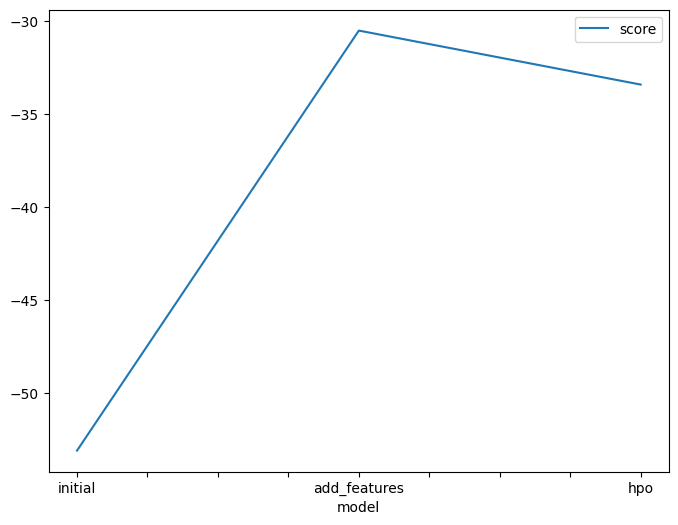

In [78]:
# Taking the top model score from each training run and creating a line plot to show improvement
# You can create these in the notebook and save them to PNG or use some other tool (e.g. google sheets, excel)
fig = pd.DataFrame(
    {
        "model": ["initial", "add_features", "hpo"],
        "score": [-53.118748, -30.499543, -33.406843]
    }
).plot(x="model", y="score", figsize=(8, 6)).get_figure()
fig.savefig('model_train_score.png')

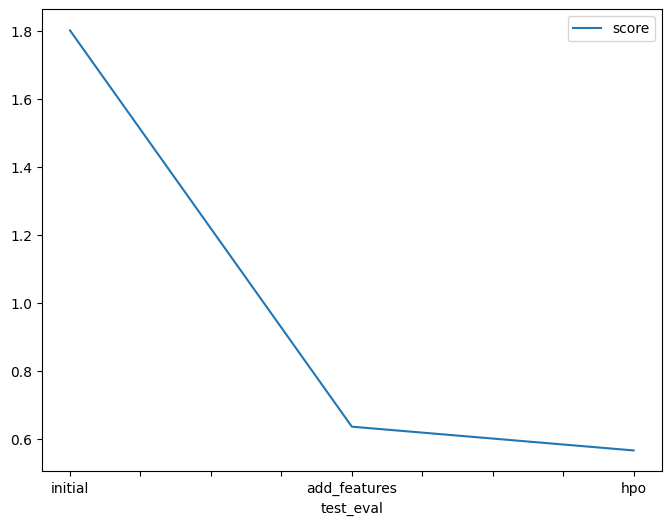

In [79]:
# Take the 3 kaggle scores and creating a line plot to show improvement
fig = pd.DataFrame(
    {
        "test_eval": ["initial", "add_features", "hpo"],
        "score": [1.80193, 0.63602, 0.56609]
    }
).plot(x="test_eval", y="score", figsize=(8, 6)).get_figure()
fig.savefig('model_test_score.png')

In [80]:
# The 3 hyperparameters we tuned with the kaggle score as the result
pd.DataFrame({
    "model": ["initial", "add_features", "hpo"],
    'CAT': ['Default','Default','depth=8, l2_leaf_reg = 10'],
    'XGB': ['Default','Default','objective:reg:pseudohubererror, eval_metric: rmse'],
    'GBM': ['Default','Default', 'GBM HPOs'],
    "score": [1.80193, 0.63602, 0.56609]
})

,model,CAT,XGB,GBM,score
0,initial,Default,Default,Default,1.80193
1,add_features,Default,Default,Default,0.63602
2,hpo,"depth=8, l2_leaf_reg = 10","objective:reg:pseudohubererror, eval_metric: rmse",GBM HPOs,0.56609
